## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [240]:
import numpy as np
import cv2, os
import glob
import matplotlib.pyplot as plt
%matplotlib inline

def calibrate_camera(images):

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.



    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

            #calculate camera calibration matrix
            ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
            dist_corr_img = cv2.undistort(img, mtx, dist, None, mtx)

    return ret, mtx, dist, rvecs, tvecs

In [241]:
def plot_images(orig_image, edited_image, fig_name):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(orig_image)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(edited_image, cmap='gray')
    ax2.set_title('Edited image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    if fig_name:
        outname = os.path.join('./output_images/', str(fig_name) + '.jpg')
        plt.imsave(outname, edited_image, cmap = 'gray') 

In [242]:
def undistort_image(image, mtx, dist):
    dst = cv2.undistort(image, mtx, dist, None, mtx)
    return dst

def gaussian_blur(image, kernel=5):
    blurred = cv2.GaussianBlur(image, (kernel,kernel), 0)
    return blurred


In [243]:
# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
ret, mtx, dist, rvecs, tvecs = calibrate_camera(images)

img = cv2.imread('test_images/test2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.undistort(img, mtx, dist, None, mtx)

def apply_sobel_operator(img, orient, sobel_kernel = 3, threshold = (0, 255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= threshold[0]) & (scaled_sobel <= threshold[1])] = 1

    return binary_output



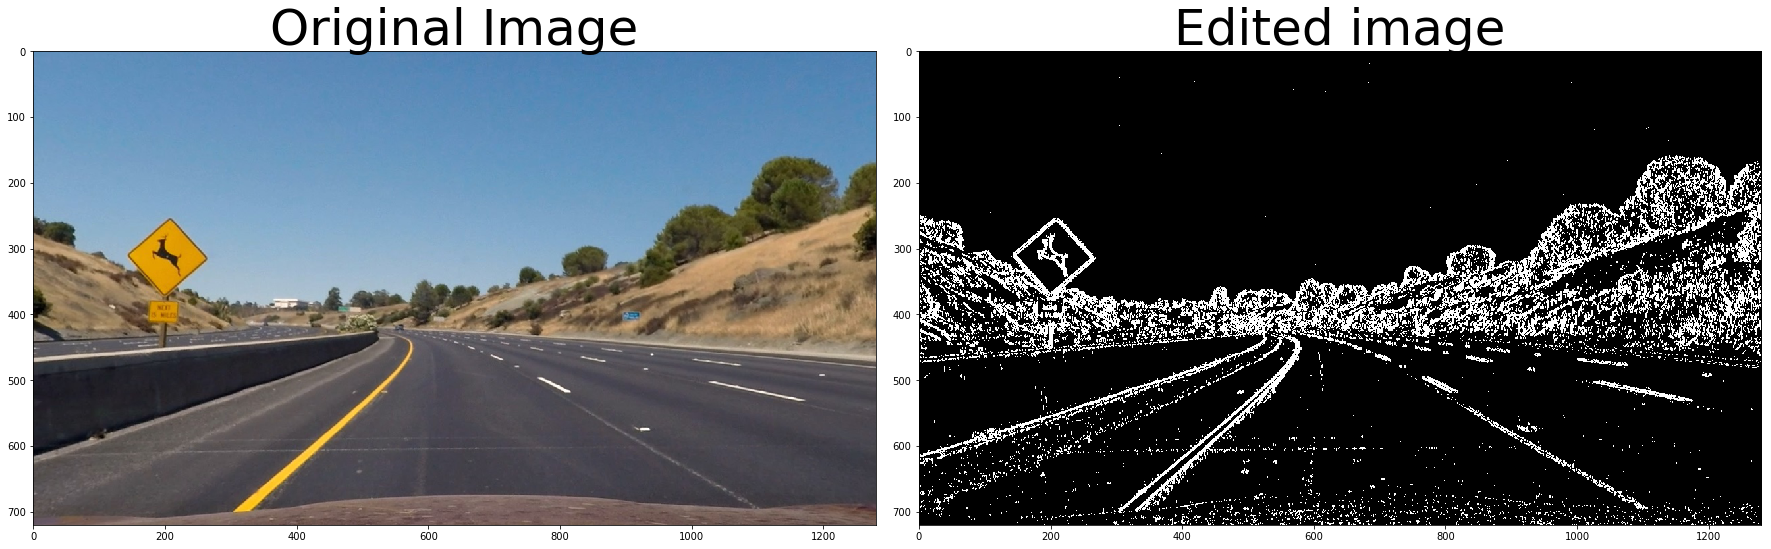

In [244]:
gradient_x = apply_sobel_operator(img, 'x', 15, (10, 200))
plt.imsave(os.path.join('./output_images/original.jpg'), img, cmap= 'gray')
plot_images(img, gradient_x, 'gradient_x')

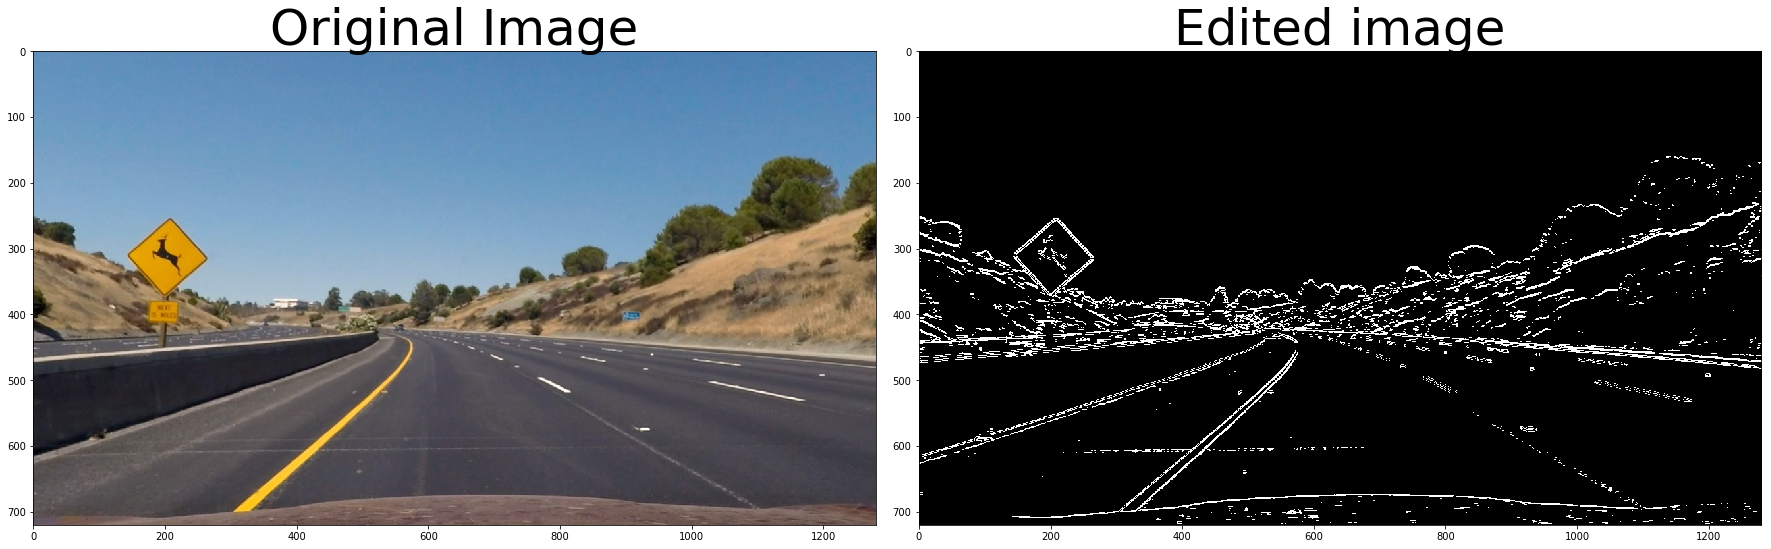

In [245]:
gradient_y = apply_sobel_operator(img, 'y', 5, (30, 100))
plot_images(img, gradient_y, 'gradient_y')

In [246]:
def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    sobel_image = np.zeros_like(gradmag)
    thresh_min, thresh_max = mag_thresh
    sobel_image[(gradmag >= thresh_min) & (gradmag <= thresh_max)] = 1
    return sobel_image


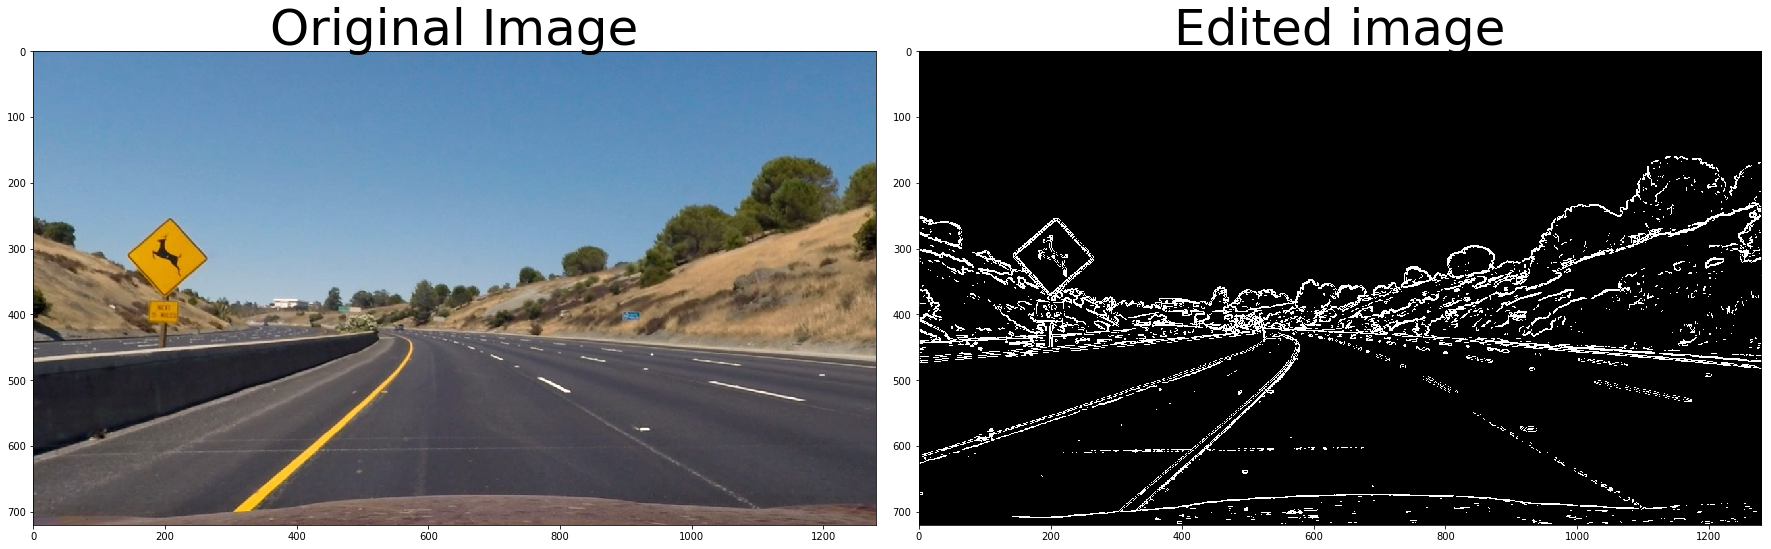

In [247]:
mag_img = mag_thresh(img, 15, (30, 100))
plot_images(img, mag_img, 'magnitude')

In [248]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    gradmag = np.arctan2(abs_sobely, abs_sobelx)
    sobel_image = np.zeros_like(gradmag)
    sobel_image[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    return sobel_image



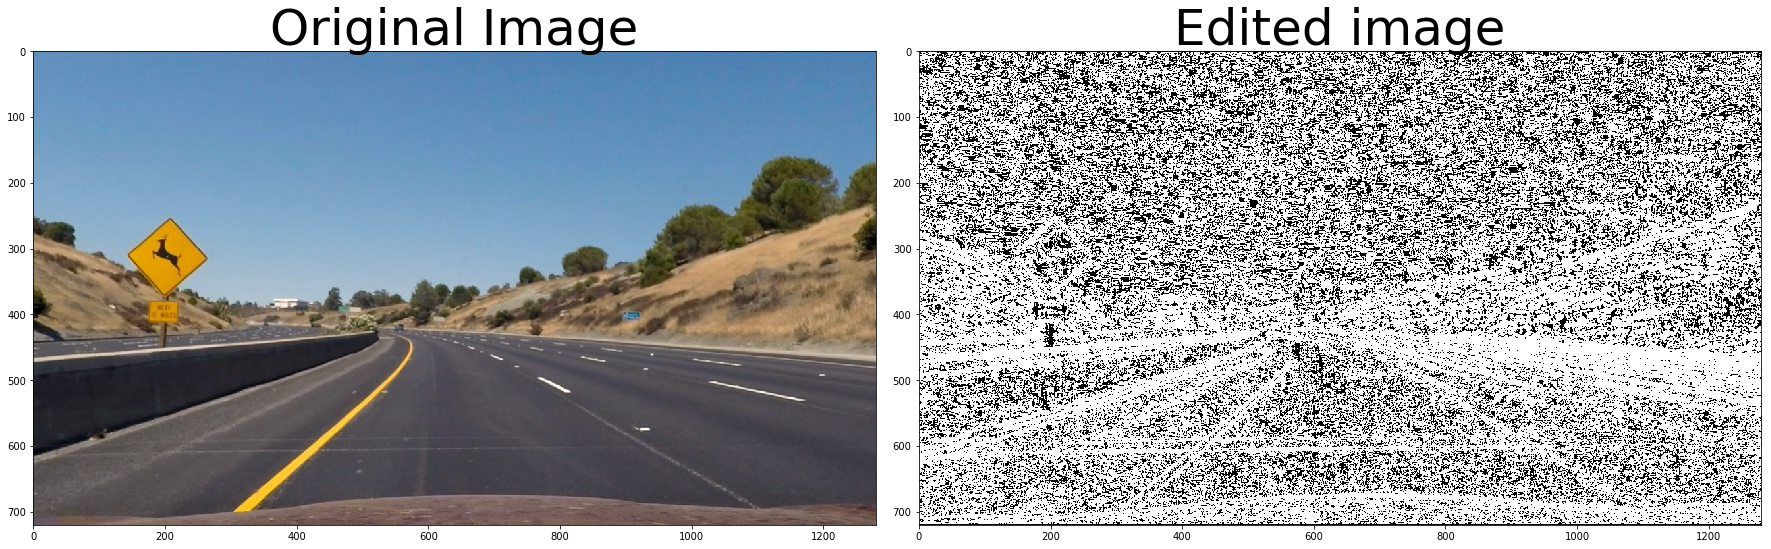

In [249]:
dir_img = dir_threshold(img, 3, thresh=(np.pi/6, np.pi/2))
plot_images(img, dir_img, 'direction')

In [250]:
def color_threshold(img,  sx_binary, dir_binary, thresh = (170, 255)):
    color_threshold = 150
    R = img[:,:,0]
    G = img[:,:,1]
    color_combined = np.zeros_like(R)
    r_g_condition = (R > color_threshold) & (G > color_threshold)
    
    combined_condition = ((sx_binary == 1) & (dir_binary == 1))

    # color channel thresholds
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    L = hls[:,:,1]
    
    # S channel performs well for detecting bright yellow and white lanes
    s_thresh = (100, 255)
    s_condition = (S > s_thresh[0]) & (S <= s_thresh[1])
    
    # We put a threshold on the L channel to avoid pixels which have shadows and as a result darker.
    l_thresh = (120, 255)
    l_condition = (L > l_thresh[0]) & (L <= l_thresh[1])

    # combine all the thresholds
    # A pixel should either be a yellowish or whiteish
    # And it should also have a gradient, as per our thresholds

    color_combined[(r_g_condition & l_condition) & (s_condition | combined_condition)] = 1
    return color_combined


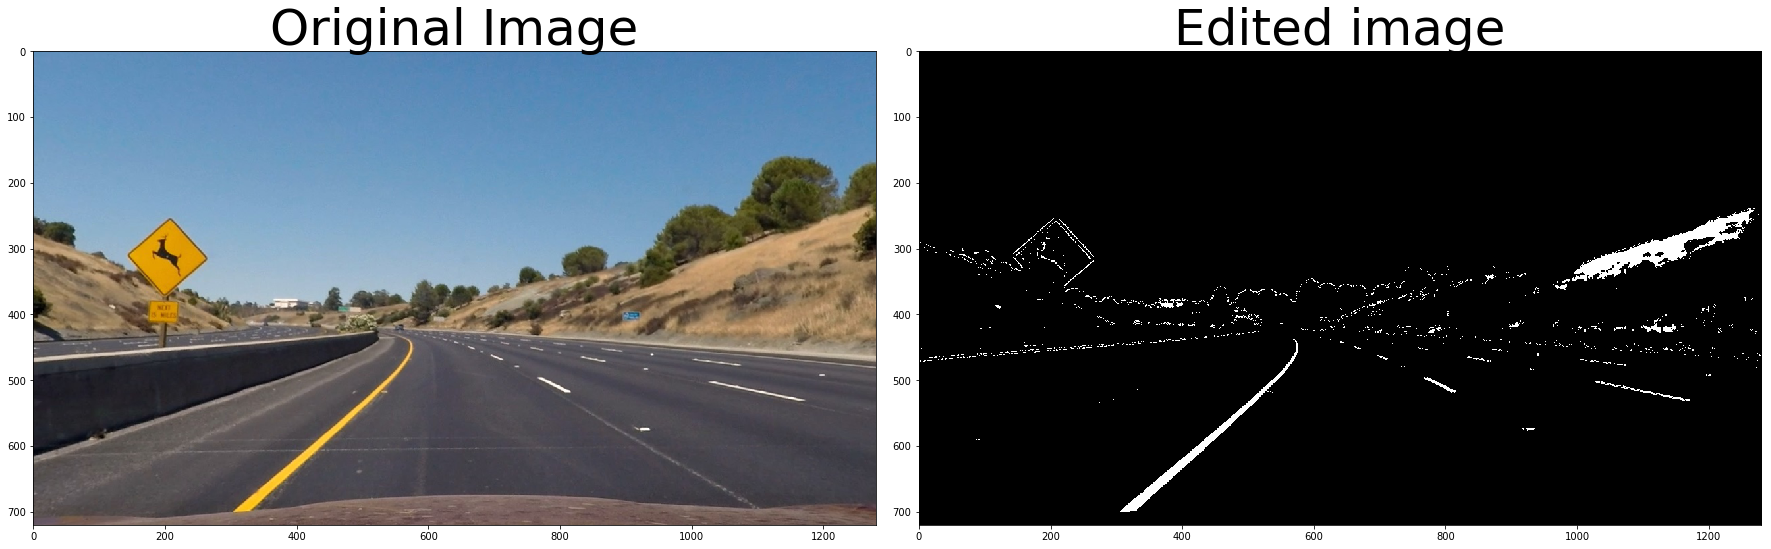

In [251]:
col_img = color_threshold(img, gradient_x, dir_img, (170, 255))
plot_images(img, col_img, 'color')

In [252]:
def combined_threshold(img):
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    # convert to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)    
    sx_binary = apply_sobel_operator(img, 'x', 15, (10, 200))
    height, width = img.shape[0], img.shape[1]
    # apply gradient direction threshold so that only edges closer to vertical are detected.
    dir_binary = dir_threshold(img, 3, thresh=(np.pi/6, np.pi/2))
    color_combined = color_threshold(img, sx_binary, dir_binary, thresh = (170, 255))
    mask = np.zeros_like(color_combined)
    region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    thresholded = cv2.bitwise_and(color_combined, mask)
    
    return thresholded


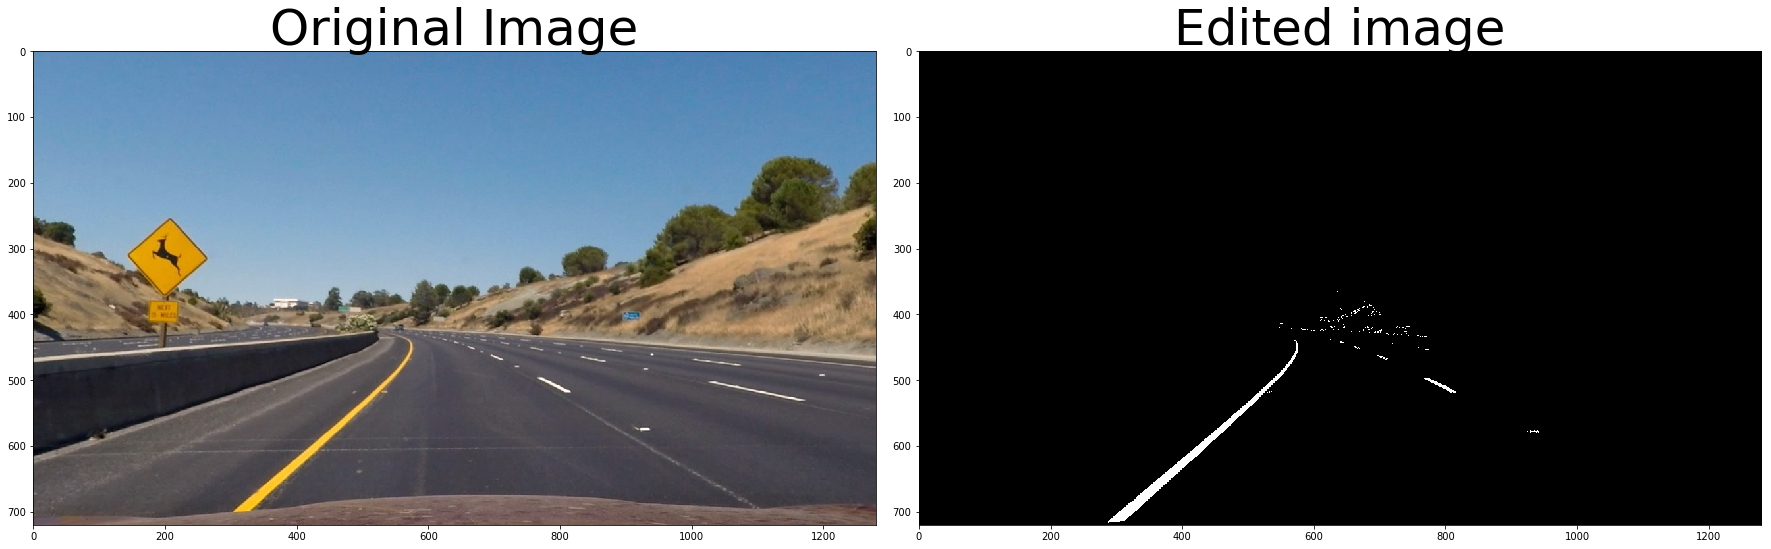

In [253]:
combined_img = combined_threshold(img)
plot_images(img, combined_img, 'combined')

In [254]:
def perspective_transform(img):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
    [[280,  700],  # Bottom left
     [595,  460],  # Top left
     [725,  460],  # Top right
     [1125, 700]]) # Bottom right

    dst = np.float32(
       [[250,  720],  # Bottom left
         [250,    0],  # Top left
         [1065,   0],  # Top right
         [1065, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, src, dst, Minv

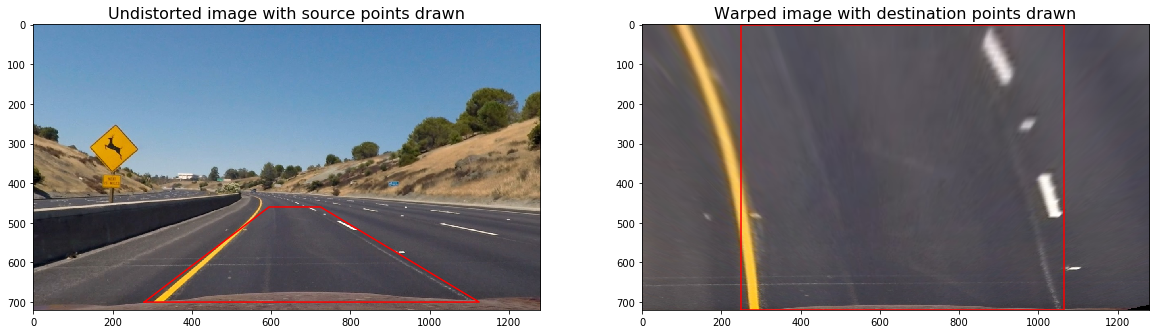

In [255]:
from matplotlib.patches import Polygon

warped_image, src, dst, M = perspective_transform(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Undistorted image with source points drawn', fontsize=16)
ax1.plot(Polygon(src).get_xy()[:, 0], Polygon(src).get_xy()[:, 1], color='red')
ax1.imshow(img)

ax2.set_title('Warped image with destination points drawn', fontsize=16)
ax2.plot(Polygon(dst).get_xy()[:, 0], Polygon(dst).get_xy()[:, 1], color='red')
ax2.imshow(warped_image)
outname = os.path.join('./output_images/' ,  'transform.jpg')
plt.imsave(outname, img)

outname = os.path.join('./output_images/' ,  'warped.jpg')
plt.imsave(outname, warped_image)

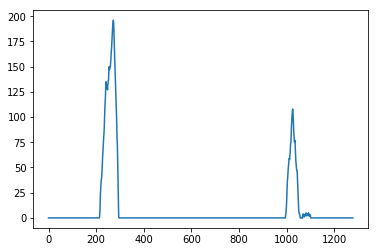

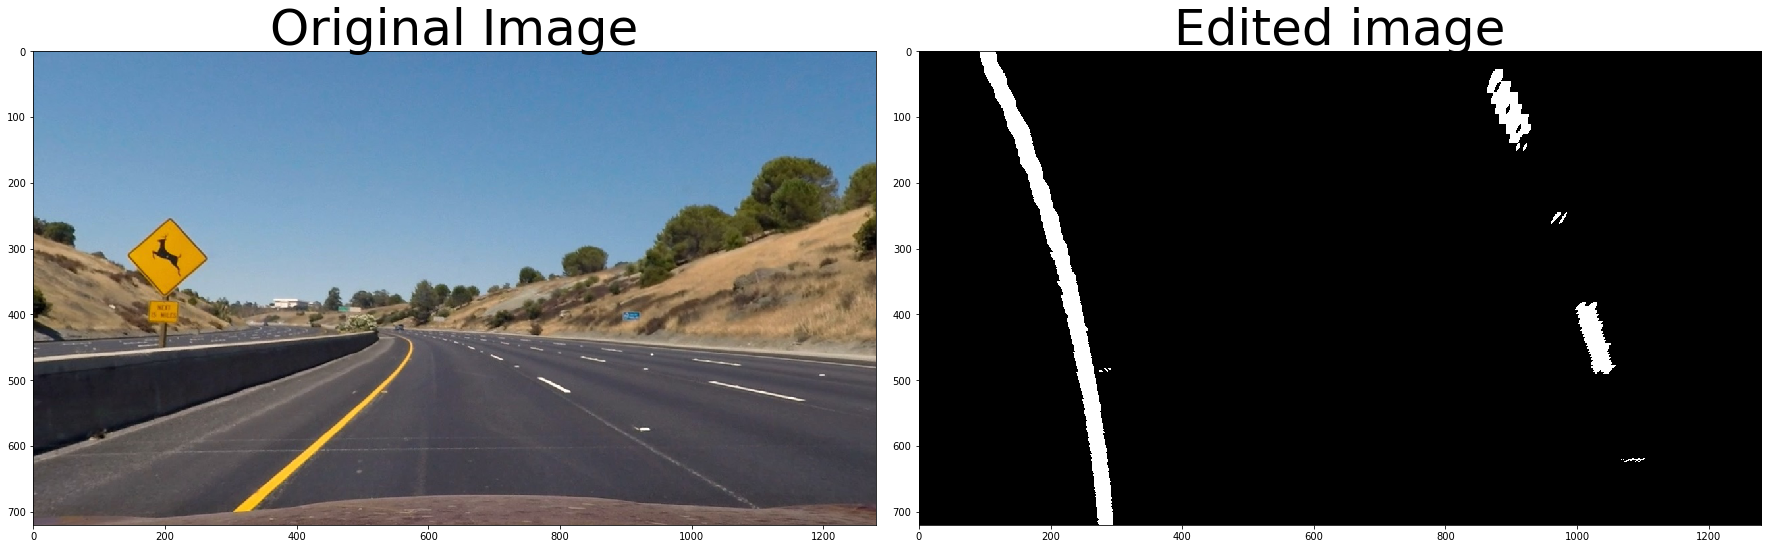

In [256]:
combined_warped_image, src, dst, M = perspective_transform(combined_img)
def hist(img):
    bottom_half = img[img.shape[0]//2:,:]
    histogram = np.sum(bottom_half, axis = 0)
    return histogram

histogram = hist(combined_warped_image)
plt.plot(histogram)

plot_images(img, combined_warped_image, 'combined_warped')

In [257]:
def find_lane_pixels(img, return_img):
    # Take a histogram of the bottom half of the image
    histogram = hist(img)
    mid = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:mid])

    # Peak in the second half indicates the likely position of the right lane
    rightx_base = np.argmax(histogram[mid:]) + mid
    if return_img:
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((img, img, img))*255

    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(img.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzerox = np.array(nonzero[1])   
    nonzeroy = np.array(nonzero[0])
   

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100

    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window + 1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if return_img:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 3) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 3) 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if return_img:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Draw left and right lines
        for index in range(img.shape[0]):
            cv2.circle(out_img, (int(left_fitx[index]), int(ploty[index])), 3, (255,255,0))
            cv2.circle(out_img, (int(right_fitx[index]), int(ploty[index])), 3, (255,255,0))
            
        return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), out_img

    return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty)

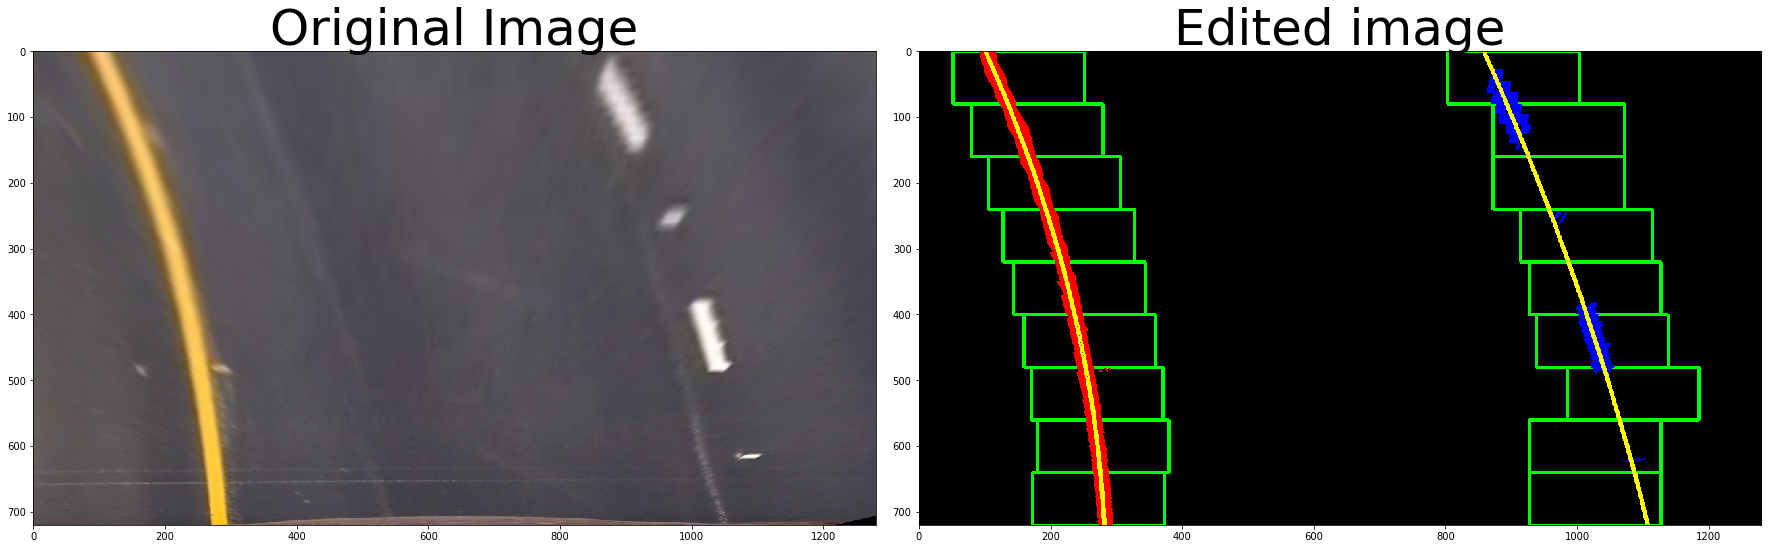

In [258]:
lines_fit, left_line, right_line, out_img = find_lane_pixels(combined_warped_image, return_img = True)
plot_images(warped_image, out_img, None)


In [259]:
def get_averaged_line(previous_lines, new_line):
    '''
        This function computes an averaged lane line by averaging over previous good frames.
    '''
    
    # Number of frames to average over
    num_frames = 12
    
    if new_line is None:
        # No line was detected
        
        if len(previous_lines) == 0:
            # If there are no previous lines, return None
            return previous_lines, None
        else:
            # Else return the last line
            return previous_lines, previous_lines[-1]
    else:
        if len(previous_lines) < num_frames:
            # we need at least num_frames frames to average over
            previous_lines.append(new_line)
            return previous_lines, new_line
        else:
            # average over the last num_frames frames
            previous_lines[0:num_frames-1] = previous_lines[1:]
            previous_lines[num_frames-1] = new_line
            new_line = np.zeros_like(new_line)
            for i in range(num_frames):
                new_line += previous_lines[i]
            new_line /= num_frames
            return previous_lines, new_line

def detect_similar_lines(img, 
                         line_fits=None,
                         past_good_left_lines=[],
                         past_good_right_lines=[],
                         running_mean_difference_between_lines = 0,
                         return_img=False):
    if line_fits is None:
        return detect_lines(img, return_img)
    
    
    left_fit = line_fits[0]
    right_fit = line_fits[1]
    
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # If any of the lines could not be found, 
    # perform a more exhaustive search
    if (leftx.size == 0 or rightx.size == 0):
        return detect_lines(img, return_img)
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    
    # If no pixels were found return None
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    

    # Smoothing
    mean_difference = np.mean(right_fitx - left_fitx)
        
    if running_mean_difference_between_lines == 0:
        running_mean_difference_between_lines = mean_difference
        
    if (mean_difference < 0.7*running_mean_difference_between_lines or mean_difference > 1.3*running_mean_difference_between_lines):
        if len(past_good_left_lines) == 0 and len(past_good_right_lines) == 0:
            return detect_lines(img, return_img)
        else:
            left_fitx = past_good_left_lines[-1]
            right_fitx = past_good_right_lines[-1]
    else:
        past_good_left_lines, left_fitx = get_averaged_line(past_good_left_lines, left_fitx)
        past_good_right_lines, right_fitx = get_averaged_line(past_good_right_lines, right_fitx)
        mean_difference = np.mean(right_fitx - left_fitx)
        running_mean_difference_between_lines = 0.9*running_mean_difference_between_lines + 0.1*mean_difference
  
        
    if return_img:
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((img, img, img))*255
        window_img = np.zeros_like(out_img)

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,250, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,250, 0))
        out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
     
        for index in range(img.shape[0]):
            cv2.circle(out_img, (int(left_fitx[index]), int(ploty[index])), 3, (255,255,0))
            cv2.circle(out_img, (int(right_fitx[index]), int(ploty[index])), 3, (255,255,0))
    
        return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), out_img
    
    return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty)

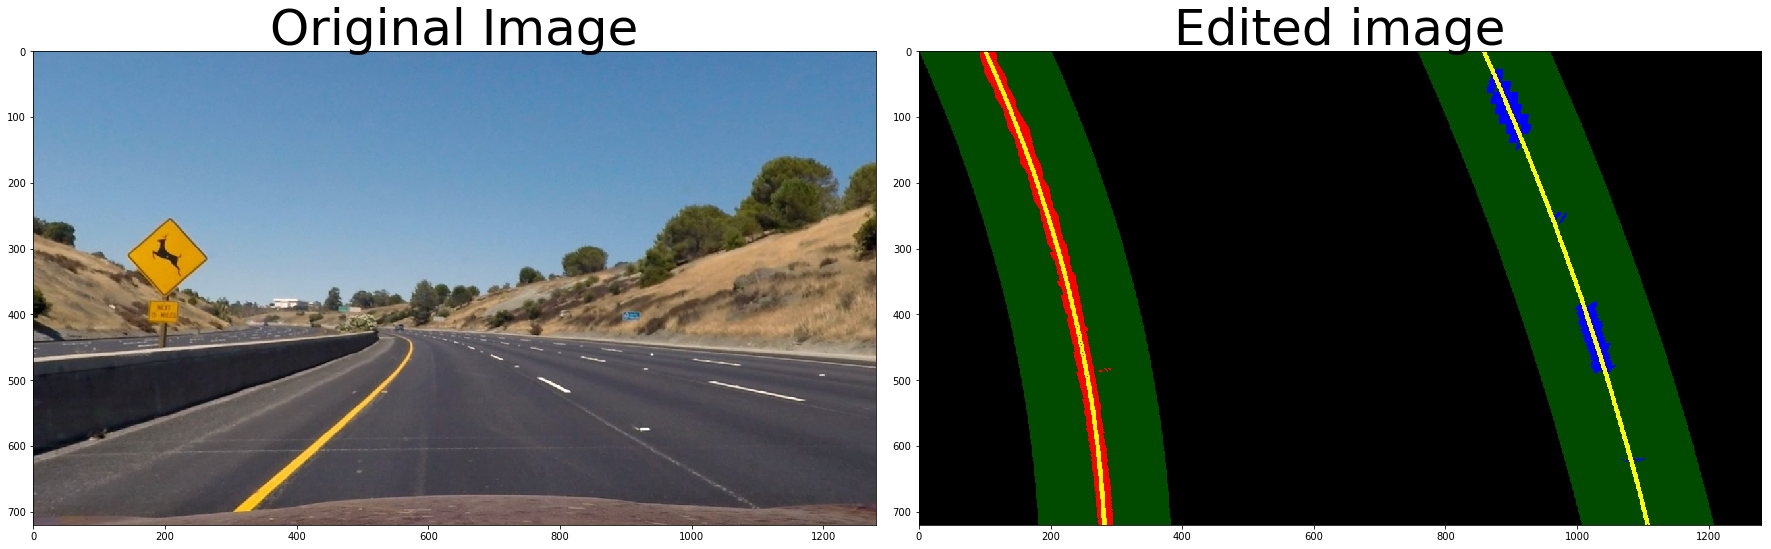

In [260]:
lines_fit, left_line, right_line, res = detect_similar_lines(combined_warped_image, lines_fit, return_img=True)
plot_images(img, res, None)

In [261]:
def curvature(leftx, rightx, img_shape):
    ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])
    
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    
    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 25/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/800 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    return (left_curverad, right_curverad)

In [262]:
curvature_val = curvature(left_line[0], right_line[0], img.shape)
print('The left curvature is ' + str(curvature_val[0]) + ' m')
print('The right curvature is ' + str(curvature_val[1]) +  ' m')

The left curvature is 477.106767241 m
The right curvature is 948.240066925 m


In [263]:
def vehicle_position(img, leftx, rightx):
    
    xm_per_pix = 3.7/800
    hor_pos = img.shape[1] // 2
    lane_pos = (leftx[-1] + rightx[-1]) / 2
    offset_x = (hor_pos - lane_pos) * xm_per_pix
    return offset_x


In [264]:
offsetx = vehicle_position(img, left_line[0], right_line[0])
print('Offset from x axis is ' + str(offsetx) + 'm')

Offset from x axis is -0.250271558123m


In [265]:
def draw_lane(img, warped_img, left_points, right_points, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    left_fitx = left_points[0]
    right_fitx = right_points[0]
    ploty = left_points[1]

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    
    # Combine the result with the original image
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)


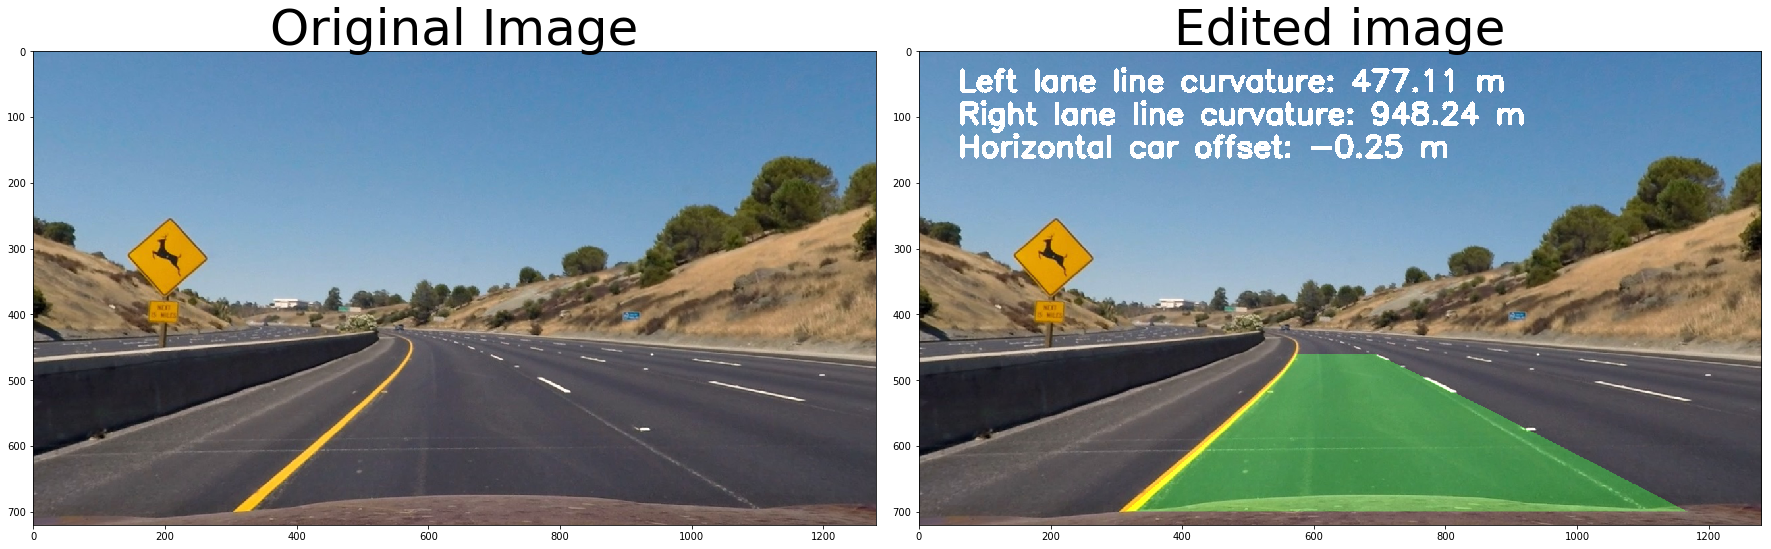

In [266]:
img_lane = draw_lane(img, combined_warped_image, left_line, right_line, M)

plt.imsave(os.path.join('./output_images/lane_boundary.jpg'), img_lane, cmap = 'gray')

cv2.putText(img_lane, 'Left lane line curvature: {:.2f} m'.format(curvature_val[0]), 
                (60, 60), cv2.FONT_ITALIC, 1.5, (255,255,255), 5)
cv2.putText(img_lane, 'Right lane line curvature: {:.2f} m'.format(curvature_val[1]), 
            (60, 110), cv2.FONT_ITALIC, 1.5, (255,255,255), 5)

# Display car offset
cv2.putText(img_lane, 'Horizontal car offset: {:.2f} m'.format(offsetx), 
            (60, 160), cv2.FONT_ITALIC, 1.5, (255,255,255), 5)

plot_images(img, img_lane, 'lane')

In [267]:
class ProcessImage:
    def __init__(self, images):
        # Make a list of calibration images
        images = glob.glob(images)

        # Calibrate camera
        self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = calibrate_camera(images)
        self.lines_fit = None

    def __call__(self, img):
        
        # Undistort the image
        undistorted = undistort_image(img, self.mtx, self.dist)
        
        # Apply gaussian blur to reduce noise
        blurred = gaussian_blur(undistorted, kernel=3)

        # Calculate directional gradient
        grad_x = apply_sobel_operator(img, orient='x', sobel_kernel=5, threshold=(10, 200))
        grad_y = apply_sobel_operator(img, orient='y', sobel_kernel=5, threshold=(10, 200))

        # Calculate gradient magnitude 
        mag_binary = mag_thresh(img, sobel_kernel=15, mag_thresh=(30, 100))

        # Calculate gradient direction
        dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(np.pi/6, np.pi/2))

        # Apply color threshold
        combined = color_threshold(blurred, grad_x, dir_binary)

        # Combine all the thresholds to identify the lane lines
        combined_warped_image = combined_threshold(img)

        # Apply a perspective transform to rectify binary image ("birds-eye view")
        combined_warped_image, src, dst, M = perspective_transform(combined)
      
        # Detect lane and draw sliding windows
        lines_fit, left_line, right_line, out_img = find_lane_pixels(combined_warped_image, return_img= True)

        # Detect lane boundaries and highlight with green
        lines_fit, left_line, right_line, res = detect_similar_lines(combined_warped_image, lines_fit, return_img= True)

        # Find radius of curvature
        curvature_val = curvature(left_line[0], right_line[0], img.shape)
        
        # Calculate car offset
        offsetx = vehicle_position(img, left_line[0], right_line[0])

        # Highligh the lane over the correct lane
        img_lane = draw_lane(img, combined_warped_image, left_line, right_line, M)
        
        cv2.putText(img_lane, 'Left lane line curvature: {:.2f} m'.format(curvature_val[0]), 
                (60, 60), cv2.FONT_ITALIC, 1.5, (255,255,255), 5)
        cv2.putText(img_lane, 'Right lane line curvature: {:.2f} m'.format(curvature_val[1]), 
                    (60, 110), cv2.FONT_ITALIC, 1.5, (255,255,255), 5)
        cv2.putText(img_lane, 'Horizontal car offset: {:.2f} m'.format(offsetx), 
                    (60, 160), cv2.FONT_ITALIC, 1.5, (255,255,255), 5)
        
        return img_lane

In [268]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

input_video = './project_video.mp4'
output_video = './solution_video.mp4'

## You may uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip(input_video)
# clip1 = VideoFileClip(input_video)

# Process video frames with our 'process_image' function
process_image = ProcessImage('./camera_cal/calibration*.jpg')

white_clip = clip1.fl_image(process_image)

%time white_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video ./solution_video.mp4
[MoviePy] Writing video ./solution_video.mp4



 12%|█▏        | 152/1261 [00:58<07:32,  2.45it/s]


 24%|██▍       | 303/1261 [01:58<06:22,  2.50it/s]


 36%|███▌      | 454/1261 [02:59<05:19,  2.53it/s]


 48%|████▊     | 605/1261 [04:02<04:36,  2.37it/s]


 60%|█████▉    | 756/1261 [05:04<03:20,  2.52it/s]


 72%|███████▏  | 907/1261 [06:04<02:19,  2.53it/s]


 84%|████████▍ | 1057/1261 [07:07<01:27,  2.34it/s]


 96%|█████████▌| 1205/1261 [08:09<00:22,  2.51it/s]


100%|█████████▉| 1260/1261 [08:31<00:00,  2.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./solution_video.mp4 

CPU times: user 6min 25s, sys: 3.32 s, total: 6min 28s
Wall time: 8min 34s
